In [1]:
# ============================================================================
# CELL 1: ENVIRONMENT SETUP
# ============================================================================
import sys
import os
from pathlib import Path

print("=" * 70)
print("PHASE 3: BASELINE TRAINING SETUP")
print("=" * 70)

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    print("✅ Google Colab detected, Drive mounted")
except ImportError:
    IN_COLAB = False
    print("✅ Local environment detected")

# Clone/update repository
if IN_COLAB:
    REPO_PATH = Path('/content/tri-objective-robust-xai-medimg')
    if not REPO_PATH.exists():
        !git clone https://github.com/viraj1011JAIN/tri-objective-robust-xai-medimg.git {REPO_PATH}
        print("✅ Repository cloned")
    else:
        os.chdir(REPO_PATH)
        !git pull origin main
        print("✅ Repository updated")

    os.chdir(REPO_PATH)
    sys.path.insert(0, str(REPO_PATH))
    PROJECT_ROOT = REPO_PATH
else:
    PROJECT_ROOT = Path.cwd().parent
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"📁 Project root: {PROJECT_ROOT}")

PHASE 3: BASELINE TRAINING SETUP
Mounted at /content/drive
✅ Google Colab detected, Drive mounted
Cloning into '/content/tri-objective-robust-xai-medimg'...
remote: Enumerating objects: 1730, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1730 (delta 1), reused 8 (delta 1), pack-reused 1716 (from 1)
Receiving objects: 100% (1730/1730), 59.20 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (669/669), done.
✅ Repository cloned
📁 Project root: /content/tri-objective-robust-xai-medimg


In [2]:
# ============================================================================
# CELL 2: INSTALL DEPENDENCIES
# ============================================================================
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q timm albumentations scikit-learn pandas matplotlib seaborn tqdm mlflow
print("✅ Dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.9 MB/s eta 0:00:00
✅ Dependencies installed


In [3]:
# ============================================================================
# CELL 3: IMPORTS
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
import json
import time
import warnings
warnings.filterwarnings('ignore')

# Albumentations for transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Project imports
from src.datasets.isic import ISICDataset
from src.models.build import build_model
from src.utils.reproducibility import set_global_seed

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ Using device: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.2 GB


In [4]:
# ============================================================================
# CELL 4: CONFIGURATION (OPTIMIZED FOR A100 40GB)
# ============================================================================
print("=" * 70)
print("CONFIGURATION (A100 OPTIMIZED)")
print("=" * 70)

# Enable TF32 for faster matrix operations on A100
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True  # Auto-tune convolution algorithms

CONFIG = {
    # Data paths (Google Drive)
    'data_root': Path('/content/drive/MyDrive/data/data/isic_2018'),
    'checkpoint_dir': Path('/content/drive/MyDrive/checkpoints/baseline'),
    'results_dir': Path('/content/drive/MyDrive/results/phase3'),

    # Model
    'model_name': 'resnet50',
    'num_classes': 7,
    'pretrained': True,

    # Training (OPTIMIZED for A100 40GB)
    'epochs': 30,
    'batch_size': 128,          # Increased from 32 → 128 for A100
    'learning_rate': 3e-4,      # Scaled up with larger batch
    'weight_decay': 1e-4,
    'num_workers': 4,           # More workers for faster data loading
    'pin_memory': True,
    'use_amp': True,            # Mixed precision training (FP16)

    # Image
    'image_size': 224,

    # Seeds for reproducibility
    'seeds': [42, 123, 456],

    # Class names
    'class_names': ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
}

# Create directories
CONFIG['checkpoint_dir'].mkdir(parents=True, exist_ok=True)
CONFIG['results_dir'].mkdir(parents=True, exist_ok=True)

for seed in CONFIG['seeds']:
    (CONFIG['checkpoint_dir'] / f'seed_{seed}').mkdir(exist_ok=True)

print(f"📊 Model: {CONFIG['model_name']}")
print(f"📊 Classes: {CONFIG['num_classes']}")
print(f"📊 Epochs: {CONFIG['epochs']}")
print(f"📊 Batch size: {CONFIG['batch_size']} (optimized for A100)")
print(f"📊 Mixed Precision (AMP): {CONFIG['use_amp']}")
print(f"📊 Seeds: {CONFIG['seeds']}")
print(f"📁 Data: {CONFIG['data_root']}")
print(f"📁 Checkpoints: {CONFIG['checkpoint_dir']}")

# Show GPU memory
if torch.cuda.is_available():
    total_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n🎮 GPU Memory: {total_mem:.1f} GB")
    print(f"🚀 TF32 enabled: {torch.backends.cuda.matmul.allow_tf32}")
    print(f"🚀 cuDNN benchmark: {torch.backends.cudnn.benchmark}")

CONFIGURATION (A100 OPTIMIZED)
📊 Model: resnet50
📊 Classes: 7
📊 Epochs: 30
📊 Batch size: 128 (optimized for A100)
📊 Mixed Precision (AMP): True
📊 Seeds: [42, 123, 456]
📁 Data: /content/drive/MyDrive/data/data/isic_2018
📁 Checkpoints: /content/drive/MyDrive/checkpoints/baseline

🎮 GPU Memory: 85.2 GB
🚀 TF32 enabled: True
🚀 cuDNN benchmark: True


In [5]:
# ============================================================================
# CELL 5: DATA PREPARATION
# ============================================================================
print("=" * 70)
print("DATA PREPARATION")
print("=" * 70)

# Fix metadata paths (Windows backslashes → forward slashes)
metadata_path = CONFIG['data_root'] / 'metadata.csv'
print(f"📄 Loading metadata: {metadata_path}")

df = pd.read_csv(metadata_path)
print(f"   Total samples: {len(df)}")

# Convert backslashes to forward slashes
if 'image_path' in df.columns:
    df['image_path'] = df['image_path'].str.replace('\\', '/', regex=False)
    print("   ✅ Fixed path separators")

# Save fixed metadata
fixed_path = CONFIG['data_root'] / 'metadata_fixed.csv'
df.to_csv(fixed_path, index=False)
print(f"   ✅ Saved to: {fixed_path}")

# Show split distribution
print(f"\n📊 Split Distribution:")
print(df['split'].value_counts())

# Show class distribution
print(f"\n📊 Class Distribution:")
print(df['label'].value_counts())

DATA PREPARATION
📄 Loading metadata: /content/drive/MyDrive/data/data/isic_2018/metadata.csv
   Total samples: 11720
   ✅ Fixed path separators
   ✅ Saved to: /content/drive/MyDrive/data/data/isic_2018/metadata_fixed.csv

📊 Split Distribution:
split
train    10015
test      1512
val        193
Name: count, dtype: int64

📊 Class Distribution:
label
NV       7737
BKL      1338
MEL      1305
BCC       622
AKIEC     378
VASC      180
DF        160
Name: count, dtype: int64


In [6]:
# ============================================================================
# CELL 6: CREATE TRANSFORMS & DATASETS
# ============================================================================
print("=" * 70)
print("CREATING DATASETS")
print("=" * 70)

# Training transforms (with augmentation)
train_transforms = A.Compose([
    A.Resize(CONFIG['image_size'], CONFIG['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Validation/Test transforms (no augmentation)
val_transforms = A.Compose([
    A.Resize(CONFIG['image_size'], CONFIG['image_size']),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Create datasets
train_dataset = ISICDataset(
    root=str(CONFIG['data_root']),
    split='train',
    transforms=train_transforms,
    csv_path=str(fixed_path),
    image_column='image_path',
    label_column='label'
)

val_dataset = ISICDataset(
    root=str(CONFIG['data_root']),
    split='val',
    transforms=val_transforms,
    csv_path=str(fixed_path),
    image_column='image_path',
    label_column='label'
)

test_dataset = ISICDataset(
    root=str(CONFIG['data_root']),
    split='test',
    transforms=val_transforms,
    csv_path=str(fixed_path),
    image_column='image_path',
    label_column='label'
)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples: {len(val_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")
print(f"✅ Classes: {train_dataset.class_names}")

CREATING DATASETS
✅ Train samples: 10015
✅ Val samples: 193
✅ Test samples: 1512
✅ Classes: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [7]:
# ============================================================================
# CELL 7: TRAINING FUNCTIONS (WITH MIXED PRECISION)
# ============================================================================
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, f1_score
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler=None, use_amp=True):
    """Train for one epoch with optional mixed precision."""
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    pbar = tqdm(dataloader, desc='Training', leave=False)
    for batch in pbar:
        # Handle (images, labels, meta) format
        if len(batch) == 3:
            images, labels, _ = batch
        else:
            images, labels = batch

        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()

        # Mixed precision forward pass
        with autocast(enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Mixed precision backward pass
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds) * 100
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device, use_amp=True):
    """Evaluate model with optional mixed precision."""
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating', leave=False):
            if len(batch) == 3:
                images, labels, _ = batch
            else:
                images, labels = batch

            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(enabled=use_amp):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs.float(), dim=1)  # Convert to float32 for softmax
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    metrics = {
        'loss': epoch_loss,
        'accuracy': accuracy_score(all_labels, all_preds) * 100,
        'balanced_accuracy': balanced_accuracy_score(all_labels, all_preds) * 100,
        'f1_macro': f1_score(all_labels, all_preds, average='macro') * 100,
    }

    # AUROC (one-vs-rest)
    try:
        metrics['auroc'] = roc_auc_score(all_labels, all_probs, multi_class='ovr') * 100
    except:
        metrics['auroc'] = 0.0

    return metrics, all_probs, all_labels, all_preds

print("✅ Training functions defined (with Mixed Precision support)")

✅ Training functions defined (with Mixed Precision support)


In [8]:
# ============================================================================
# CELL 8: MAIN TRAINING LOOP (OPTIMIZED FOR A100)
# ============================================================================
print("=" * 70)
print("BASELINE TRAINING - ALL SEEDS (A100 OPTIMIZED)")
print("=" * 70)

all_seed_results = {}
training_history = {}

# Initialize GradScaler for mixed precision
scaler = GradScaler() if CONFIG['use_amp'] else None
print(f"🚀 Mixed Precision (AMP): {'Enabled' if CONFIG['use_amp'] else 'Disabled'}")

for seed_idx, seed in enumerate(CONFIG['seeds']):
    print(f"\n{'='*70}")
    print(f"SEED {seed} ({seed_idx+1}/{len(CONFIG['seeds'])})")
    print(f"{'='*70}")

    # Set seed for reproducibility
    set_global_seed(seed)

    # Clear GPU cache before each seed
    torch.cuda.empty_cache()

    # Create data loaders (optimized)
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory'],
        persistent_workers=True,  # Keep workers alive between epochs
        prefetch_factor=2         # Prefetch batches
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'] * 2,  # Larger batch for eval (no gradients)
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory'],
        persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'] * 2,
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory']
    )

    # Build model
    model = build_model(
        architecture=CONFIG['model_name'],
        num_classes=CONFIG['num_classes'],
        pretrained=CONFIG['pretrained']
    ).to(device)

    # Compile model for faster execution (PyTorch 2.0+)
    if hasattr(torch, 'compile'):
        try:
            model = torch.compile(model, mode='reduce-overhead')
            print("   🚀 Model compiled with torch.compile()")
        except:
            print("   ⚠️ torch.compile() not available, using eager mode")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CONFIG['epochs'], eta_min=1e-6
    )

    # Reset scaler for each seed
    if CONFIG['use_amp']:
        scaler = GradScaler()

    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auroc': []}
    best_val_auroc = 0.0

    print(f"\n📊 Training for {CONFIG['epochs']} epochs...")
    print(f"   Batch size: {CONFIG['batch_size']} | LR: {CONFIG['learning_rate']}")
    start_time = time.time()

    for epoch in range(CONFIG['epochs']):
        # Train with mixed precision
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device,
            scaler=scaler, use_amp=CONFIG['use_amp']
        )

        # Validate
        val_metrics, _, _, _ = evaluate(
            model, val_loader, criterion, device,
            use_amp=CONFIG['use_amp']
        )

        # Update scheduler
        scheduler.step()

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_auroc'].append(val_metrics['auroc'])

        # Save best model
        if val_metrics['auroc'] > best_val_auroc:
            best_val_auroc = val_metrics['auroc']
            checkpoint_path = CONFIG['checkpoint_dir'] / f'seed_{seed}' / 'best.pt'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_auroc': best_val_auroc,
                'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()},
            }, checkpoint_path)

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0 or epoch == 0:
            gpu_mem = torch.cuda.max_memory_allocated() / 1e9 if torch.cuda.is_available() else 0
            print(f"  Epoch {epoch+1:2d}/{CONFIG['epochs']} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.1f}% | "
                  f"Val Acc: {val_metrics['accuracy']:.1f}% | Val AUROC: {val_metrics['auroc']:.1f}% | "
                  f"GPU: {gpu_mem:.1f}GB")

    elapsed = time.time() - start_time
    samples_per_sec = len(train_dataset) * CONFIG['epochs'] / elapsed
    print(f"\n⏱️  Training time: {elapsed/60:.1f} minutes ({samples_per_sec:.0f} samples/sec)")

    # Final test evaluation
    print(f"\n📊 Final Test Evaluation...")

    # Load best model
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_metrics, test_probs, test_labels, test_preds = evaluate(
        model, test_loader, criterion, device, use_amp=CONFIG['use_amp']
    )

    print(f"\n✅ SEED {seed} RESULTS:")
    print(f"   Test Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"   Test Balanced Acc: {test_metrics['balanced_accuracy']:.2f}%")
    print(f"   Test AUROC: {test_metrics['auroc']:.2f}%")
    print(f"   Test F1 (macro): {test_metrics['f1_macro']:.2f}%")
    print(f"   Checkpoint: {checkpoint_path}")

    # Store results
    all_seed_results[seed] = test_metrics
    training_history[seed] = history

    # Free memory
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

print(f"\n{'='*70}")
print("ALL SEEDS COMPLETE")
print(f"{'='*70}")

BASELINE TRAINING - ALL SEEDS (A100 OPTIMIZED)
🚀 Mixed Precision (AMP): Enabled

SEED 42 (1/3)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 235MB/s]


   🚀 Model compiled with torch.compile()

📊 Training for 30 epochs...
   Batch size: 128 | LR: 0.0003


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch  1/30 | Train Loss: 0.6956 | Train Acc: 75.5% | Val Acc: 81.9% | Val AUROC: 97.4% | GPU: 5.9GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch  5/30 | Train Loss: 0.3640 | Train Acc: 86.3% | Val Acc: 82.4% | Val AUROC: 97.0% | GPU: 5.9GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 10/30 | Train Loss: 0.2302 | Train Acc: 91.4% | Val Acc: 85.5% | Val AUROC: 97.0% | GPU: 5.9GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 15/30 | Train Loss: 0.1337 | Train Acc: 95.2% | Val Acc: 86.0% | Val AUROC: 97.6% | GPU: 5.9GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 20/30 | Train Loss: 0.0556 | Train Acc: 98.0% | Val Acc: 86.5% | Val AUROC: 97.9% | GPU: 5.9GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 25/30 | Train Loss: 0.0283 | Train Acc: 99.0% | Val Acc: 87.0% | Val AUROC: 98.2% | GPU: 5.9GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 30/30 | Train Loss: 0.0169 | Train Acc: 99.6% | Val Acc: 88.6% | Val AUROC: 97.9% | GPU: 5.9GB

⏱️  Training time: 53.2 minutes (94 samples/sec)

📊 Final Test Evaluation...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


✅ SEED 42 RESULTS:
   Test Accuracy: 82.74%
   Test Balanced Acc: 67.88%
   Test AUROC: 96.03%
   Test F1 (macro): 72.33%
   Checkpoint: /content/drive/MyDrive/checkpoints/baseline/seed_42/best.pt

SEED 123 (2/3)
   🚀 Model compiled with torch.compile()

📊 Training for 30 epochs...
   Batch size: 128 | LR: 0.0003


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch  1/30 | Train Loss: 0.6987 | Train Acc: 75.0% | Val Acc: 76.2% | Val AUROC: 96.4% | GPU: 6.3GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch  5/30 | Train Loss: 0.3893 | Train Acc: 85.7% | Val Acc: 78.8% | Val AUROC: 94.3% | GPU: 6.3GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 10/30 | Train Loss: 0.2438 | Train Acc: 91.5% | Val Acc: 83.9% | Val AUROC: 97.2% | GPU: 6.3GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 15/30 | Train Loss: 0.1263 | Train Acc: 95.6% | Val Acc: 88.1% | Val AUROC: 97.8% | GPU: 6.3GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 20/30 | Train Loss: 0.0715 | Train Acc: 97.5% | Val Acc: 87.6% | Val AUROC: 97.9% | GPU: 6.3GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 25/30 | Train Loss: 0.0306 | Train Acc: 99.0% | Val Acc: 88.6% | Val AUROC: 98.4% | GPU: 6.3GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 30/30 | Train Loss: 0.0203 | Train Acc: 99.4% | Val Acc: 87.0% | Val AUROC: 98.0% | GPU: 6.3GB

⏱️  Training time: 22.4 minutes (224 samples/sec)

📊 Final Test Evaluation...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


✅ SEED 123 RESULTS:
   Test Accuracy: 84.33%
   Test Balanced Acc: 72.06%
   Test AUROC: 96.64%
   Test F1 (macro): 74.71%
   Checkpoint: /content/drive/MyDrive/checkpoints/baseline/seed_123/best.pt

SEED 456 (3/3)
   🚀 Model compiled with torch.compile()

📊 Training for 30 epochs...
   Batch size: 128 | LR: 0.0003


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch  1/30 | Train Loss: 0.6780 | Train Acc: 76.1% | Val Acc: 75.1% | Val AUROC: 92.2% | GPU: 6.4GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch  5/30 | Train Loss: 0.3574 | Train Acc: 87.1% | Val Acc: 86.0% | Val AUROC: 97.9% | GPU: 6.4GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 10/30 | Train Loss: 0.2394 | Train Acc: 91.3% | Val Acc: 85.5% | Val AUROC: 97.9% | GPU: 6.4GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 15/30 | Train Loss: 0.1283 | Train Acc: 95.4% | Val Acc: 81.9% | Val AUROC: 96.9% | GPU: 6.4GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 20/30 | Train Loss: 0.0521 | Train Acc: 98.1% | Val Acc: 86.5% | Val AUROC: 97.4% | GPU: 6.4GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 25/30 | Train Loss: 0.0285 | Train Acc: 99.1% | Val Acc: 88.6% | Val AUROC: 97.5% | GPU: 6.4GB


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

  Epoch 30/30 | Train Loss: 0.0188 | Train Acc: 99.4% | Val Acc: 89.6% | Val AUROC: 97.6% | GPU: 6.4GB

⏱️  Training time: 22.1 minutes (227 samples/sec)

📊 Final Test Evaluation...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


✅ SEED 456 RESULTS:
   Test Accuracy: 82.08%
   Test Balanced Acc: 67.99%
   Test AUROC: 96.41%
   Test F1 (macro): 70.94%
   Checkpoint: /content/drive/MyDrive/checkpoints/baseline/seed_456/best.pt

ALL SEEDS COMPLETE


In [9]:
# ============================================================================
# CELL 9: AGGREGATE RESULTS
# ============================================================================
print("=" * 70)
print("AGGREGATED RESULTS (MEAN ± STD)")
print("=" * 70)

# Aggregate across seeds
metrics_list = ['accuracy', 'balanced_accuracy', 'auroc', 'f1_macro']

print("\n📊 Test Set Performance:")
print("-" * 50)

aggregated = {}
for metric in metrics_list:
    values = [all_seed_results[seed][metric] for seed in CONFIG['seeds']]
    mean_val = np.mean(values)
    std_val = np.std(values)
    aggregated[metric] = {'mean': mean_val, 'std': std_val}
    print(f"   {metric:20s}: {mean_val:.2f}% ± {std_val:.2f}%")

print("\n📊 Per-Seed Results:")
print("-" * 50)
for seed in CONFIG['seeds']:
    r = all_seed_results[seed]
    print(f"   Seed {seed}: Acc={r['accuracy']:.1f}%, AUROC={r['auroc']:.1f}%")

# Save results
results_file = CONFIG['results_dir'] / 'baseline_results.json'
with open(results_file, 'w') as f:
    json.dump({
        'per_seed': {str(k): v for k, v in all_seed_results.items()},
        'aggregated': aggregated,
        'config': {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()}
    }, f, indent=2)
print(f"\n✅ Results saved to: {results_file}")

AGGREGATED RESULTS (MEAN ± STD)

📊 Test Set Performance:
--------------------------------------------------
   accuracy            : 83.05% ± 0.94%
   balanced_accuracy   : 69.31% ± 1.94%
   auroc               : 96.36% ± 0.25%
   f1_macro            : 72.66% ± 1.56%

📊 Per-Seed Results:
--------------------------------------------------
   Seed 42: Acc=82.7%, AUROC=96.0%
   Seed 123: Acc=84.3%, AUROC=96.6%
   Seed 456: Acc=82.1%, AUROC=96.4%

✅ Results saved to: /content/drive/MyDrive/results/phase3/baseline_results.json


TRAINING VISUALIZATIONS
✅ Saved: /content/drive/MyDrive/results/phase3/training_curves.png


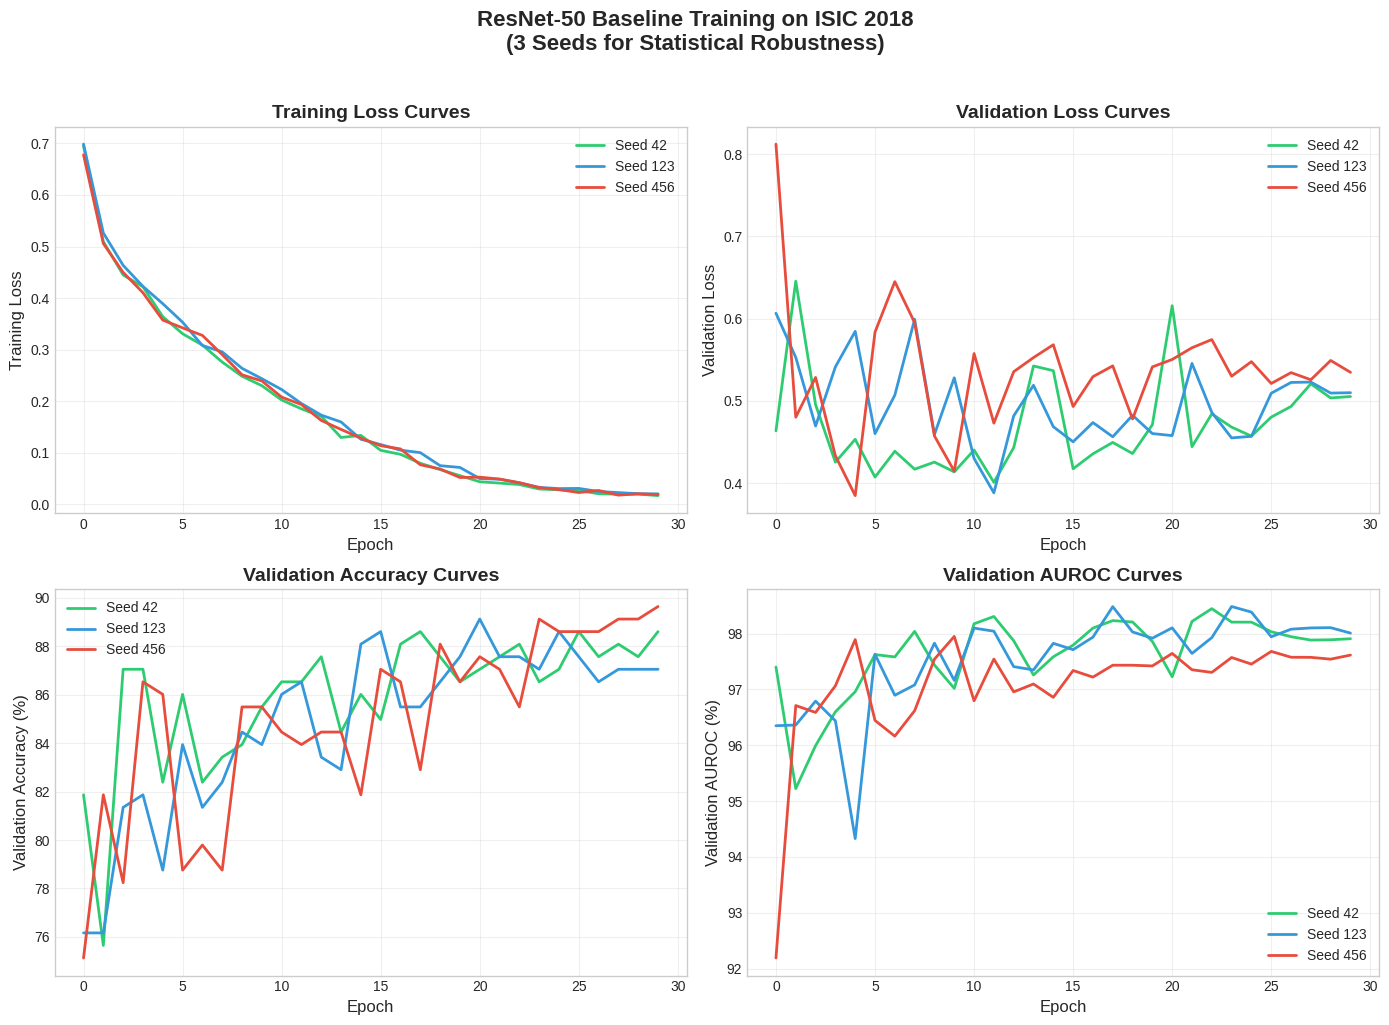

In [10]:
# ============================================================================
# CELL 10: VISUALIZATION - TRAINING CURVES
# ============================================================================
print("=" * 70)
print("TRAINING VISUALIZATIONS")
print("=" * 70)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#2ecc71', '#3498db', '#e74c3c']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training Loss
ax = axes[0, 0]
for i, seed in enumerate(CONFIG['seeds']):
    ax.plot(training_history[seed]['train_loss'], label=f'Seed {seed}', color=colors[i], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)
ax.set_title('Training Loss Curves', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Validation Loss
ax = axes[0, 1]
for i, seed in enumerate(CONFIG['seeds']):
    ax.plot(training_history[seed]['val_loss'], label=f'Seed {seed}', color=colors[i], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Loss', fontsize=12)
ax.set_title('Validation Loss Curves', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Validation Accuracy
ax = axes[1, 0]
for i, seed in enumerate(CONFIG['seeds']):
    ax.plot(training_history[seed]['val_acc'], label=f'Seed {seed}', color=colors[i], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation Accuracy (%)', fontsize=12)
ax.set_title('Validation Accuracy Curves', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Validation AUROC
ax = axes[1, 1]
for i, seed in enumerate(CONFIG['seeds']):
    ax.plot(training_history[seed]['val_auroc'], label=f'Seed {seed}', color=colors[i], linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation AUROC (%)', fontsize=12)
ax.set_title('Validation AUROC Curves', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('ResNet-50 Baseline Training on ISIC 2018\n(3 Seeds for Statistical Robustness)',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
fig_path = CONFIG['results_dir'] / 'training_curves.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

✅ Saved: /content/drive/MyDrive/results/phase3/seed_comparison.png


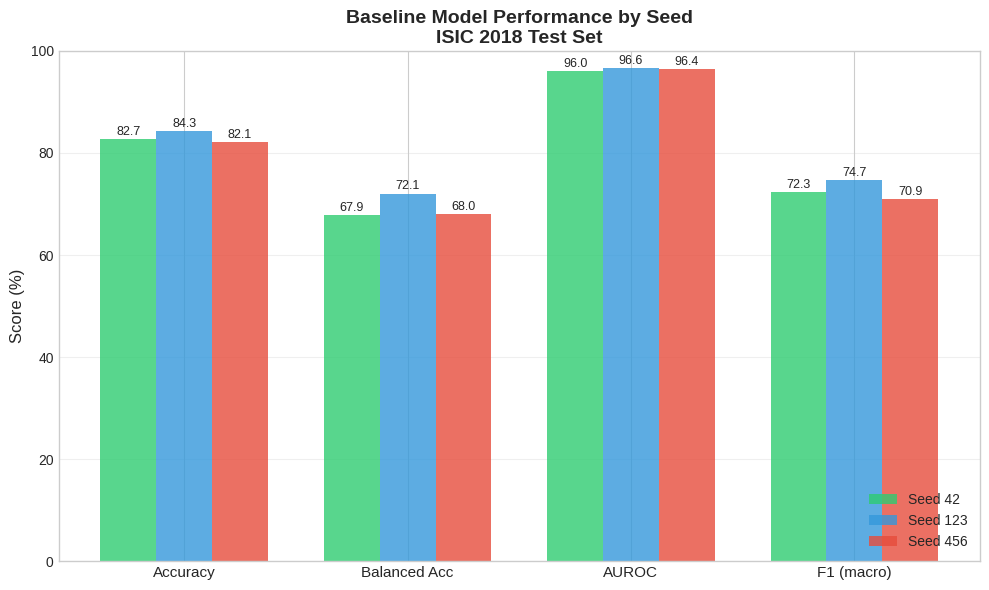

In [11]:
# ============================================================================
# CELL 11: VISUALIZATION - FINAL RESULTS BAR CHART
# ============================================================================
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Balanced Acc', 'AUROC', 'F1 (macro)']
metric_keys = ['accuracy', 'balanced_accuracy', 'auroc', 'f1_macro']

x = np.arange(len(metrics))
width = 0.25

for i, seed in enumerate(CONFIG['seeds']):
    values = [all_seed_results[seed][k] for k in metric_keys]
    bars = ax.bar(x + i*width, values, width, label=f'Seed {seed}', color=colors[i], alpha=0.8)

    # Add value labels
    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.1f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                   xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Baseline Model Performance by Seed\nISIC 2018 Test Set', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right')
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig_path = CONFIG['results_dir'] / 'seed_comparison.png'
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved: {fig_path}")
plt.show()

In [12]:
# ============================================================================
# CELL 12: FINAL SUMMARY
# ============================================================================
print("=" * 70)
print("PHASE 3 COMPLETE - FINAL SUMMARY")
print("=" * 70)

print("\n📊 BASELINE MODEL PERFORMANCE (Mean ± Std):")
print("-" * 50)
print(f"   Accuracy:      {aggregated['accuracy']['mean']:.2f}% ± {aggregated['accuracy']['std']:.2f}%")
print(f"   Balanced Acc:  {aggregated['balanced_accuracy']['mean']:.2f}% ± {aggregated['balanced_accuracy']['std']:.2f}%")
print(f"   AUROC:         {aggregated['auroc']['mean']:.2f}% ± {aggregated['auroc']['std']:.2f}%")
print(f"   F1 (macro):    {aggregated['f1_macro']['mean']:.2f}% ± {aggregated['f1_macro']['std']:.2f}%")

print("\n📁 SAVED CHECKPOINTS:")
print("-" * 50)
for seed in CONFIG['seeds']:
    ckpt_path = CONFIG['checkpoint_dir'] / f'seed_{seed}' / 'best.pt'
    if ckpt_path.exists():
        size_mb = ckpt_path.stat().st_size / (1024*1024)
        print(f"   ✅ seed_{seed}/best.pt ({size_mb:.1f} MB)")
    else:
        print(f"   ❌ seed_{seed}/best.pt - NOT FOUND")

print("\n🎯 NEXT STEPS:")
print("-" * 50)
print("   1. Run Phase 4 notebook for adversarial robustness evaluation")
print("   2. Use these checkpoints as baseline comparison")
print("   3. Proceed to Phase 5 tri-objective robust training")

print("\n" + "=" * 70)
print("✅ PHASE 3 BASELINE TRAINING COMPLETE!")
print("=" * 70)

PHASE 3 COMPLETE - FINAL SUMMARY

📊 BASELINE MODEL PERFORMANCE (Mean ± Std):
--------------------------------------------------
   Accuracy:      83.05% ± 0.94%
   Balanced Acc:  69.31% ± 1.94%
   AUROC:         96.36% ± 0.25%
   F1 (macro):    72.66% ± 1.56%

📁 SAVED CHECKPOINTS:
--------------------------------------------------
   ✅ seed_42/best.pt (269.6 MB)
   ✅ seed_123/best.pt (269.6 MB)
   ✅ seed_456/best.pt (269.6 MB)

🎯 NEXT STEPS:
--------------------------------------------------
   1. Run Phase 4 notebook for adversarial robustness evaluation
   2. Use these checkpoints as baseline comparison
   3. Proceed to Phase 5 tri-objective robust training

✅ PHASE 3 BASELINE TRAINING COMPLETE!
